<a href="https://colab.research.google.com/github/angadbajwa23/Brain-Image-Segmentation/blob/master/Attention_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My Drive/2d

/content/gdrive/My Drive/2d


In [0]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 2.7MB/s 


Importing Libraries


In [0]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt


import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Using TensorFlow backend.


In [0]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

In [0]:
images = images[..., np.newaxis]

In [0]:
masks = masks[..., np.newaxis]

Normalizing Images

In [0]:
for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.mean(images[i,:, :]))/ np.std(images[i,:, :])

In [0]:
images.shape

(3064, 512, 512, 1)

Splitting the dataset into Traing, Validation and Test sets


In [0]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_test, images_cv, masks_test, masks_cv = train_test_split(images_test,masks_test,test_size = 0.5,train_size =0.5,random_state=1)
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of development examples = " + str(images_cv.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))
print ("Images_val (dev) shape: " + str(images_cv.shape))
print ("Masks_val (dev) shape: " + str(masks_cv.shape))
print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

number of training examples = 2451
number of development examples = 307
number of test examples = 306
Images_train shape: (2451, 512, 512, 1)
Masks_train shape: (2451, 512, 512, 1)
Images_val (dev) shape: (307, 512, 512, 1)
Masks_val (dev) shape: (307, 512, 512, 1)
Images_test shape: (306, 512, 512, 1)
Masks_test shape: (306, 512, 512, 1)


Evalution Metrics


In [0]:
from keras.losses import binary_crossentropy
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Model


In [0]:
#Res+U-Net
def unet_2():
    inputs = Input((512,512, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conc1 = concatenate([inputs, conv1], axis=3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conc1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conc2 = concatenate([pool1, conv2], axis=3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conc2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conc3 = concatenate([pool2, conv3], axis=3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conc3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conc4 = concatenate([pool3, conv4], axis=3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conc4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conc5 = concatenate([pool4, conv5], axis=3)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conc6 = concatenate([up6, conv6], axis=3)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conc7 = concatenate([up7, conv7], axis=3)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conc8 = concatenate([up8, conv8], axis=3)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conc9 = concatenate([up9, conv9], axis=3)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()

    model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199), loss=[bce_dice_loss], metrics=[dice_coef])

    return model


In [0]:
filepath="cnn-parameters-improvement-{epoch:02d}-{dice_coef:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("checkpoints/{}.model".format(filepath, monitor=[dice_coef], verbose=1, save_best_only=True, mode='max'))

Train the Model

In [0]:
model=unet_2()
model.fit(images_train, masks_train, batch_size=2, nb_epoch=30, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 512, 512, 33) 0           input_2[0][0]                    
                                                                 conv2d_21[0][0]            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 2451 samples, validate on 307 samples
Epoch 1/30
2451/2451 [==============================] - 572s 233ms/step - loss: 0.1240 - dice_coef: 0.0416 - val_loss: 0.0659 - val_dice_coef: 0.0461
Epoch 2/30
2451/2451 [==============================] - 570s 233ms/step - loss: 0.0680 - dice_coef: 0.0635 - val_loss: 0.0610 - val_dice_coef: 0.0686
Epoch 3/30
2451/2451 [==============================] - 570s 232ms/step - loss: 0.0637 - dice_coef: 0.0859 - val_loss: 0.0568 - val_dice_coef: 0.1076
Epoch 4/30
2451/2451 [==============================] - 570s 233ms/step - loss: 0.0588 - dice_coef: 0.1314 - val_loss: 0.0522 - val_dice_coef: 0.1478
Epoch 5/30
2451/2451 [==============================] - 569s 232ms/step - loss: 0.0545 - dice_coef: 0.1878 - val_loss: 0.0500 - val_dice_coef: 0.2095
Epoch 6/30
2451/2451 [==============================] - 568s 232ms/step - loss: 0.0518 - dice_coef: 0.2297 - val_loss: 0.0473 - val_dice_coef: 0.2545
Epoch 7/30
2451/2451 [==============================]

In [0]:
dependencies = {
     'dice_coef': dice_coef
}
model = tf.keras.models.load_model('/content/gdrive/My Drive/2d/checkpoints/cnn-parameters-improvement-30-0.73.model', custom_objects=dependencies)

Training a bit more!

In [0]:
model.fit(images_train, masks_train, batch_size=2, epochs=20, verbose=1,validation_data=(images_cv,masks_cv))

Epoch 1/20
1226/1226 [==============================] - 130s 106ms/step - loss: 0.0147 - dice_coef: 0.7344 - val_loss: 0.0365 - val_dice_coef: 0.5351
Epoch 2/20
1226/1226 [==============================] - 128s 105ms/step - loss: 0.0134 - dice_coef: 0.7527 - val_loss: 0.0369 - val_dice_coef: 0.5315
Epoch 3/20
1226/1226 [==============================] - 128s 104ms/step - loss: 0.0121 - dice_coef: 0.7703 - val_loss: 0.0383 - val_dice_coef: 0.5410
Epoch 4/20
1226/1226 [==============================] - 128s 105ms/step - loss: 0.0119 - dice_coef: 0.7752 - val_loss: 0.0340 - val_dice_coef: 0.5685
Epoch 5/20
1226/1226 [==============================] - 127s 104ms/step - loss: 0.0114 - dice_coef: 0.7873 - val_loss: 0.0340 - val_dice_coef: 0.5447
Epoch 6/20
1226/1226 [==============================] - 127s 104ms/step - loss: 0.0106 - dice_coef: 0.7974 - val_loss: 0.0381 - val_dice_coef: 0.5745
Epoch 7/20
1226/1226 [==============================] - 128s 104ms/step - loss: 0.0101 - dice_coef: 

In [0]:
model.save('Res-net.h5')

Evaluation on Test set


In [0]:
results=model.evaluate(images_test,masks_test,batch_size=2)
print(results)

153/153 [==============================] - 5s 35ms/step - loss: 0.0537 - dice_coef: 0.6102
[0.053693559020757675, 0.6101779341697693]


Prediction 


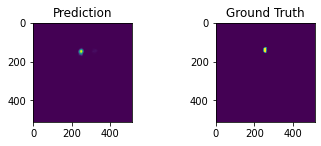

In [0]:
predictions = model.predict(images_train[0:1,:])
plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_train[0,:,:,0])